In [1]:
!pip3 install beautifulsoup4 --quiet
!pip3 install lxml --quiet
!pip3 install requests --quiet
!pip3 install nltk --quiet
!pip3 install spacy --quiet
!pip3 install seab
!python3 -m spacy download en_core_web_sm --quiet
!pip3 install imblearn --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement seab (from versions: none)
ERROR: No matching distribution found for seab

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via 

After the following experiminets, we found Penalised SVM and Logistic Regression to be the best models
Next we will try to tune the hyperparameters of these models to see if we can improve the performance
We will use GridSearchCV to tune the hyperparameters


In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

news = fetch_20newsgroups(subset='all') # subset='all' means we want all the data ( train + test)
prefix = "/home/codespace/scikit_learn_data/20news_home/"
df = pd.DataFrame({'text': news.data, 'category': news.target, 'filename': news.filenames})
# removing the prefix from the filename
df['topic'] = df['filename'].apply(lambda x: x.split("/")[-2])
# dropping the filename column
df.drop(columns=['filename'], inplace=True)

df[df['category'] == 10].head()



,text,category,topic
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
8,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
24,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
44,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


In [3]:
# category where topic is comp.sys.ibm.pc.hardware

df[df['topic'] == 'comp.sys.ibm.pc.hardware'].head()



,text,category,topic
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
70,From: dwayne@stratsft.uucp (Dwayne Bailey)\nSu...,3,comp.sys.ibm.pc.hardware
95,From: jcmorris@mbunix.mitre.org (Morris)\nSubj...,3,comp.sys.ibm.pc.hardware
120,"From: ""Mohammad Al-Ansari"" <alansari@mango.ucs...",3,comp.sys.ibm.pc.hardware


In [4]:
# print a random text
print(df['topic'][0])
print(df['text'][0])


rec.sport.hockey
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




## Extracting Categories from File Storage Folder Names

Utilizing the folder names of the file storage, we can successfully extract the categories for each article in the Newsgroup20 dataset. Once the extraction is complete, we can proceed to drop the filename since it is no longer necessary for our analysis.

### Addressing Imbalance in Average Text Length by Topic

Upon examining the average text length of each article relative to its topic, we might identify an imbalance. It is crucial to address this imbalance, aligning with our efforts to handle class imbalances between the different categories. This ensures a more equitable representation of topics in our dataset, contributing to a more robust and unbiased analysis.

In [5]:
stop_word_add_on = ['from', 'to', 'subject', 'go', 'one', 'use', 'say', 'would', 'know', 'get', 'would', 'articl', 'think', 'get ', 'universe', 'like', 'know','univers', 'use', 'ask', 'want']


In [6]:
# A test attempt to extract name and email from text
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import ssl
from nltk.stem.snowball import SnowballStemmer
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')



def strip_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def strip_numeric(text):
    return re.sub(r'\d+', '', text)

def strip_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def strip_multiple_whitespaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_newline(text):
    return text.replace('\n', '')

def transform_to_lower(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    # add more words to the set
    stop_words.update(stop_word_add_on)
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_single_char(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if len(word) > 1]
    return ' '.join(filtered_words)

def stem_text(text):
    stemmer = SnowballStemmer("english")
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def clean_text(text):
    if text is None:
        return ""
    text = strip_tags(text)
    text = strip_numeric(text)
    text = strip_punctuation(text)
    text = remove_newline(text)
    text = strip_multiple_whitespaces(text)
    text = transform_to_lower(text)
    text = remove_stopwords(text)
    text = remove_single_char(text)
    text = stem_text(text)
    return text

# check if cleaned_data.csv exists
import os

df['clean_text'] = df['text'].apply(clean_text)
df.to_csv("cleaned_data.csv", index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anushkrishnav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anushkrishnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/1s/d6cby_d90fsfb94qvy0p0ttm0000gn/T/ipykernel_83567/3102370166.py:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [7]:
df.head()


,text,category,topic,clean_text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,mamatha devineni ratnam pen fan reactionsorgan...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,mblawsonmidwayecnuoknoredu matthew lawsonsubje...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,hilmierdsvsus hilmi erensubject armenia say co...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,guydaustinibmcom guy dawsonsubject ide vs scsi...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,alexand samuel mcdiarmid driver organ sophomor...


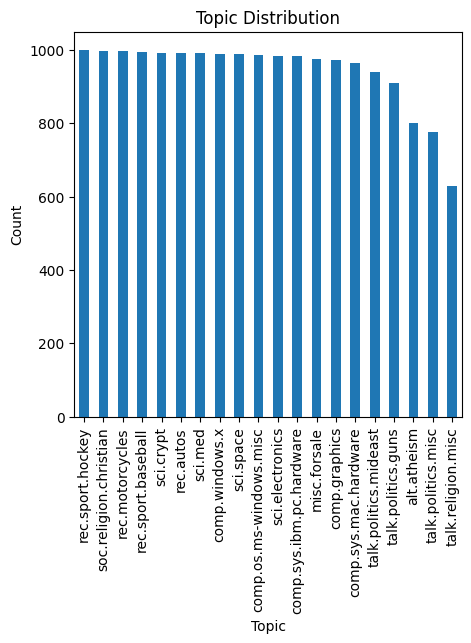

In [8]:
# topic distribution
df['topic'].value_counts().plot(kind='bar', figsize=(5, 5))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()


In [9]:
df

,text,category,topic,clean_text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,mamatha devineni ratnam pen fan reactionsorgan...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,mblawsonmidwayecnuoknoredu matthew lawsonsubje...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,hilmierdsvsus hilmi erensubject armenia say co...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,guydaustinibmcom guy dawsonsubject ide vs scsi...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,alexand samuel mcdiarmid driver organ sophomor...
...,...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med,jimzisfeinfactorycom jim zisfein migrain scans...
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12,sci.electronics,rdellcbnewsfcbattcom richardbdellsubject quest...
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware,westesnetcomcom estessubject mount cpu cooler ...
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics,stevehcrlgw steven collinssubject sphere point...


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Assuming df contains the dataset

# Split the data into train (75%), validation (10%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(df[['clean_text', 'ibm_hardware_freq', 'sale_price_freq','graphic_imag_freq']], df['topic'], test_size=0.25, random_state=42, stratify=df['topic'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)

text_transformer = ('text', Pipeline([('tfidf', TfidfVectorizer(analyzer='word', max_features=10000)), 
                                      ('scaler', MaxAbsScaler())]), 'clean_text')

numeric_transformer = ('numeric', 'passthrough', ['ibm_hardware_freq', 'sale_price_freq', 'graphic_imag_freq'])

preprocessor = ColumnTransformer(
    transformers=[
        text_transformer,
        numeric_transformer,
    ]
)

# Create a parameter grid

param_grid = {
    'classifier__svc__C': [0.1, 1, 10],
    'classifier__svc__penalty': ['l1', 'l2'],
    'classifier__svc__max_iter': [500, 1000],
    'classifier__svc__dual': [False],
    'classifier__logreg__multi_class': ['multinomial'],
    'classifier__logreg__max_iter': [5000, 10000],
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier',
                              VotingClassifier(estimators=[('svc', LinearSVC(C=0.1, dual=False, max_iter=500)),
                                                         ('logreg', LogisticRegression(class_weight='balanced', max_iter=5000, multi_class='multinomial')),
                                                         ]))])

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best params
print(grid_search.best_params_)
# Best score
print(grid_search.best_score_)
# Best estimator
print(grid_search.best_estimator_)
# Best index
print(grid_search.best_index_)
# Best results
print(grid_search.cv_results_)
# Best F1




Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.6min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.6min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__cl

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_b

[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=b

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=0.1, classifier__vc__class_weig

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_wei

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.6min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weigh

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 5.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 5.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 5.1min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 5.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 5.1min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weig

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_wei

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__cl

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_we

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=5000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.7min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_we

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_b

[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.8min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weigh

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_wei

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_b

[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__cl

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.4min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_b

[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=9000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_w

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.4min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.4min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=0.1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weigh

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__cl

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_we

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=1, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__cl

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 1.9min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_we

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=500, classifier__svc__penalty=l2, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.0min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.1min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=0.1, classifier__vc_

/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.3min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min


/Users/anushkrishnav/.local/share/virtualenvs/newsgroup-u5VajpjS/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=1, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__class_weight=balanced, classifier__vc__kernel=linear; total time= 2.2min
[CV] END classifier__logreg__class_weight=balanced, classifier__logreg__max_iter=10000, classifier__logreg__multi_class=multinomial, classifier__svc__C=10, classifier__svc__dual=False, classifier__svc__max_iter=1000, classifier__svc__penalty=l1, classifier__vc__C=10, classifier__vc__cla

In [69]:
print(grid_search.best_estimator_.score(X_test, y_test))
# classification report
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


0.8976127320954908
                          precision    recall  f1-score   support

             alt.atheism       0.88      0.89      0.88        80
           comp.graphics       0.80      0.86      0.83        97
 comp.os.ms-windows.misc       0.83      0.80      0.81        99
comp.sys.ibm.pc.hardware       0.78      0.84      0.81        98
   comp.sys.mac.hardware       0.84      0.84      0.84        96
          comp.windows.x       0.86      0.88      0.87        99
            misc.forsale       0.78      0.76      0.77        98
               rec.autos       0.89      0.89      0.89        99
         rec.motorcycles       0.92      0.92      0.92       100
      rec.sport.baseball       0.98      0.94      0.96        99
        rec.sport.hockey       0.97      0.98      0.98       100
               sci.crypt       0.98      0.97      0.97        99
         sci.electronics       0.84      0.89      0.87        98
                 sci.med       0.92      0.95      0.94 

In [ ]:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=12000)),
                                                                  ('scaler',
                                                                   MaxAbsScaler())]),
                                                  'clean_text'),
                                                 ('numeric', 'passthrough',
                                                  ['ibm_hardware_freq'])])),
                ('classifier',
                 VotingClassifier(estimators=[('svc',
                                               LinearSVC(C=0.1, dual=False,
                                                         max_iter=500)),
                                              ('logreg',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=5000,
                                                                  multi_class='multinomial')),
                                              ('vc',
                                               SVC(C=10,
                                                   class_weight='balanced',
                                                   kernel='linear'))]))])

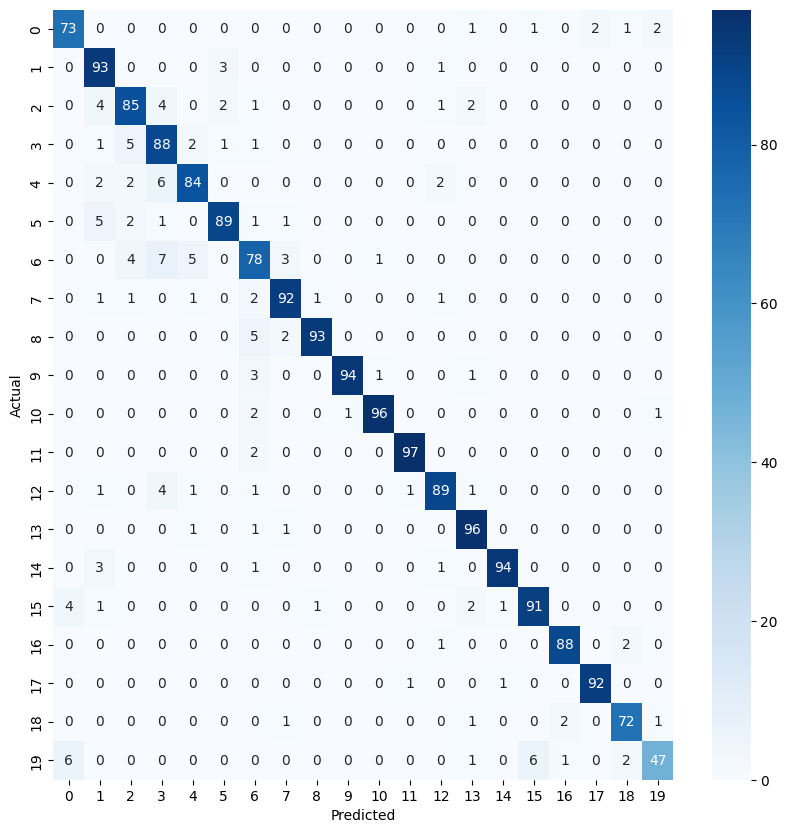

In [22]:
# heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
